# 프로젝트 루브릭
- 데이터 전처리, 모델학습, 예측의 전체 과정을 거쳐 캐글 submission까지 전과정이 성공적으로 진행되었는가?
- 제출된 노트북이 캐글 커널로 사용될 수 있을 만큼 전처리, 학습, 최적화 진행 과정이 체계적으로 기술되었는가?
- 다양한 피처 엔지니어링과 하이퍼 파라미터 튜닝 등의 최적화 기법을 통해 캐글 리더보드의 Private score 기준 110000 이하의 점수를 얻었는가?

# import
- 앞으로 사용 할 모듈과 메소드를 미리 호출하려합니다.

In [1]:
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import warnings
warnings.filterwarnings("ignore")

import os
from os.path import join

import pandas as pd
import numpy as np

import missingno as msno

from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import KFold, cross_val_score
import xgboost as xgb
import lightgbm as lgb

import matplotlib.pyplot as plt
import seaborn as sns

print('Done')


Done


# load
- CSV 파일을 로드합니다. 로컬에서 진행되었기 때문에 별도로 경로를 지정해주고 그 경로를 변수에 할당합니다.
- train.csv와 test.csv를 각각의 변수에 할당합니다.

In [2]:
data_dir = os.getenv('USERPROFILE')+'/Exploration/03_Kaggle/data'

train_data_path = join(data_dir, 'train.csv')
test_data_path = join(data_dir, 'test.csv') 

train = pd.read_csv(train_data_path)
test = pd.read_csv(test_data_path)

print('Done')

Done


# basic preprocessing
- 기본적인 전처리를 하려합니다.
    1. date column을 가용한 int타입으로 전처리
    2. price(=target data)를 임시 저장 후 삭제
    3. 불필요한 id column을 삭제
    4. 위 과정을 test에 대해서도 수행

In [3]:
# date column 처리
train['date'] = train['date'].apply(lambda i: i[:6]).astype(int)

train.head()

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,0,201410,221900.0,3,1.00,1180,5650,1.0,0,0,...,7,1180,0,1955,0,98178,47.5112,-122.257,1340,5650
1,1,201502,180000.0,2,1.00,770,10000,1.0,0,0,...,6,770,0,1933,0,98028,47.7379,-122.233,2720,8062
2,2,201502,510000.0,3,2.00,1680,8080,1.0,0,0,...,8,1680,0,1987,0,98074,47.6168,-122.045,1800,7503
3,3,201406,257500.0,3,2.25,1715,6819,2.0,0,0,...,7,1715,0,1995,0,98003,47.3097,-122.327,2238,6819
4,4,201501,291850.0,3,1.50,1060,9711,1.0,0,0,...,7,1060,0,1963,0,98198,47.4095,-122.315,1650,9711


In [4]:
# target = price 임시저장 후 삭제
y = train['price']
del train['price']

print(train.columns)

Index(['id', 'date', 'bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot',
       'floors', 'waterfront', 'view', 'condition', 'grade', 'sqft_above',
       'sqft_basement', 'yr_built', 'yr_renovated', 'zipcode', 'lat', 'long',
       'sqft_living15', 'sqft_lot15'],
      dtype='object')


In [5]:
# 불필요한 id column 삭제
del train['id']

print(train.columns)

Index(['date', 'bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot', 'floors',
       'waterfront', 'view', 'condition', 'grade', 'sqft_above',
       'sqft_basement', 'yr_built', 'yr_renovated', 'zipcode', 'lat', 'long',
       'sqft_living15', 'sqft_lot15'],
      dtype='object')


In [6]:
# test data에 대해서도 같은 작업 수행(test에는 target이 없음)
test['date'] = test['date'].apply(lambda i: i[:6]).astype(int)
del test['id']

print(test.columns)

Index(['date', 'bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot', 'floors',
       'waterfront', 'view', 'condition', 'grade', 'sqft_above',
       'sqft_basement', 'yr_built', 'yr_renovated', 'zipcode', 'lat', 'long',
       'sqft_living15', 'sqft_lot15'],
      dtype='object')


In [7]:
train_len = len(train)
        # train_len에 training data 개수를 저장해서 추후에 학습데이터만 불러올 수 있는 인덱스로 사용합니다.
data = pd.concat((train, test), axis=0)
        # 전체 데이터에 대해 탐색해보기 위해 두 데이터를 pd.concat 으로 합쳐봅니다.

+ 결측치 확인

<AxesSubplot:>

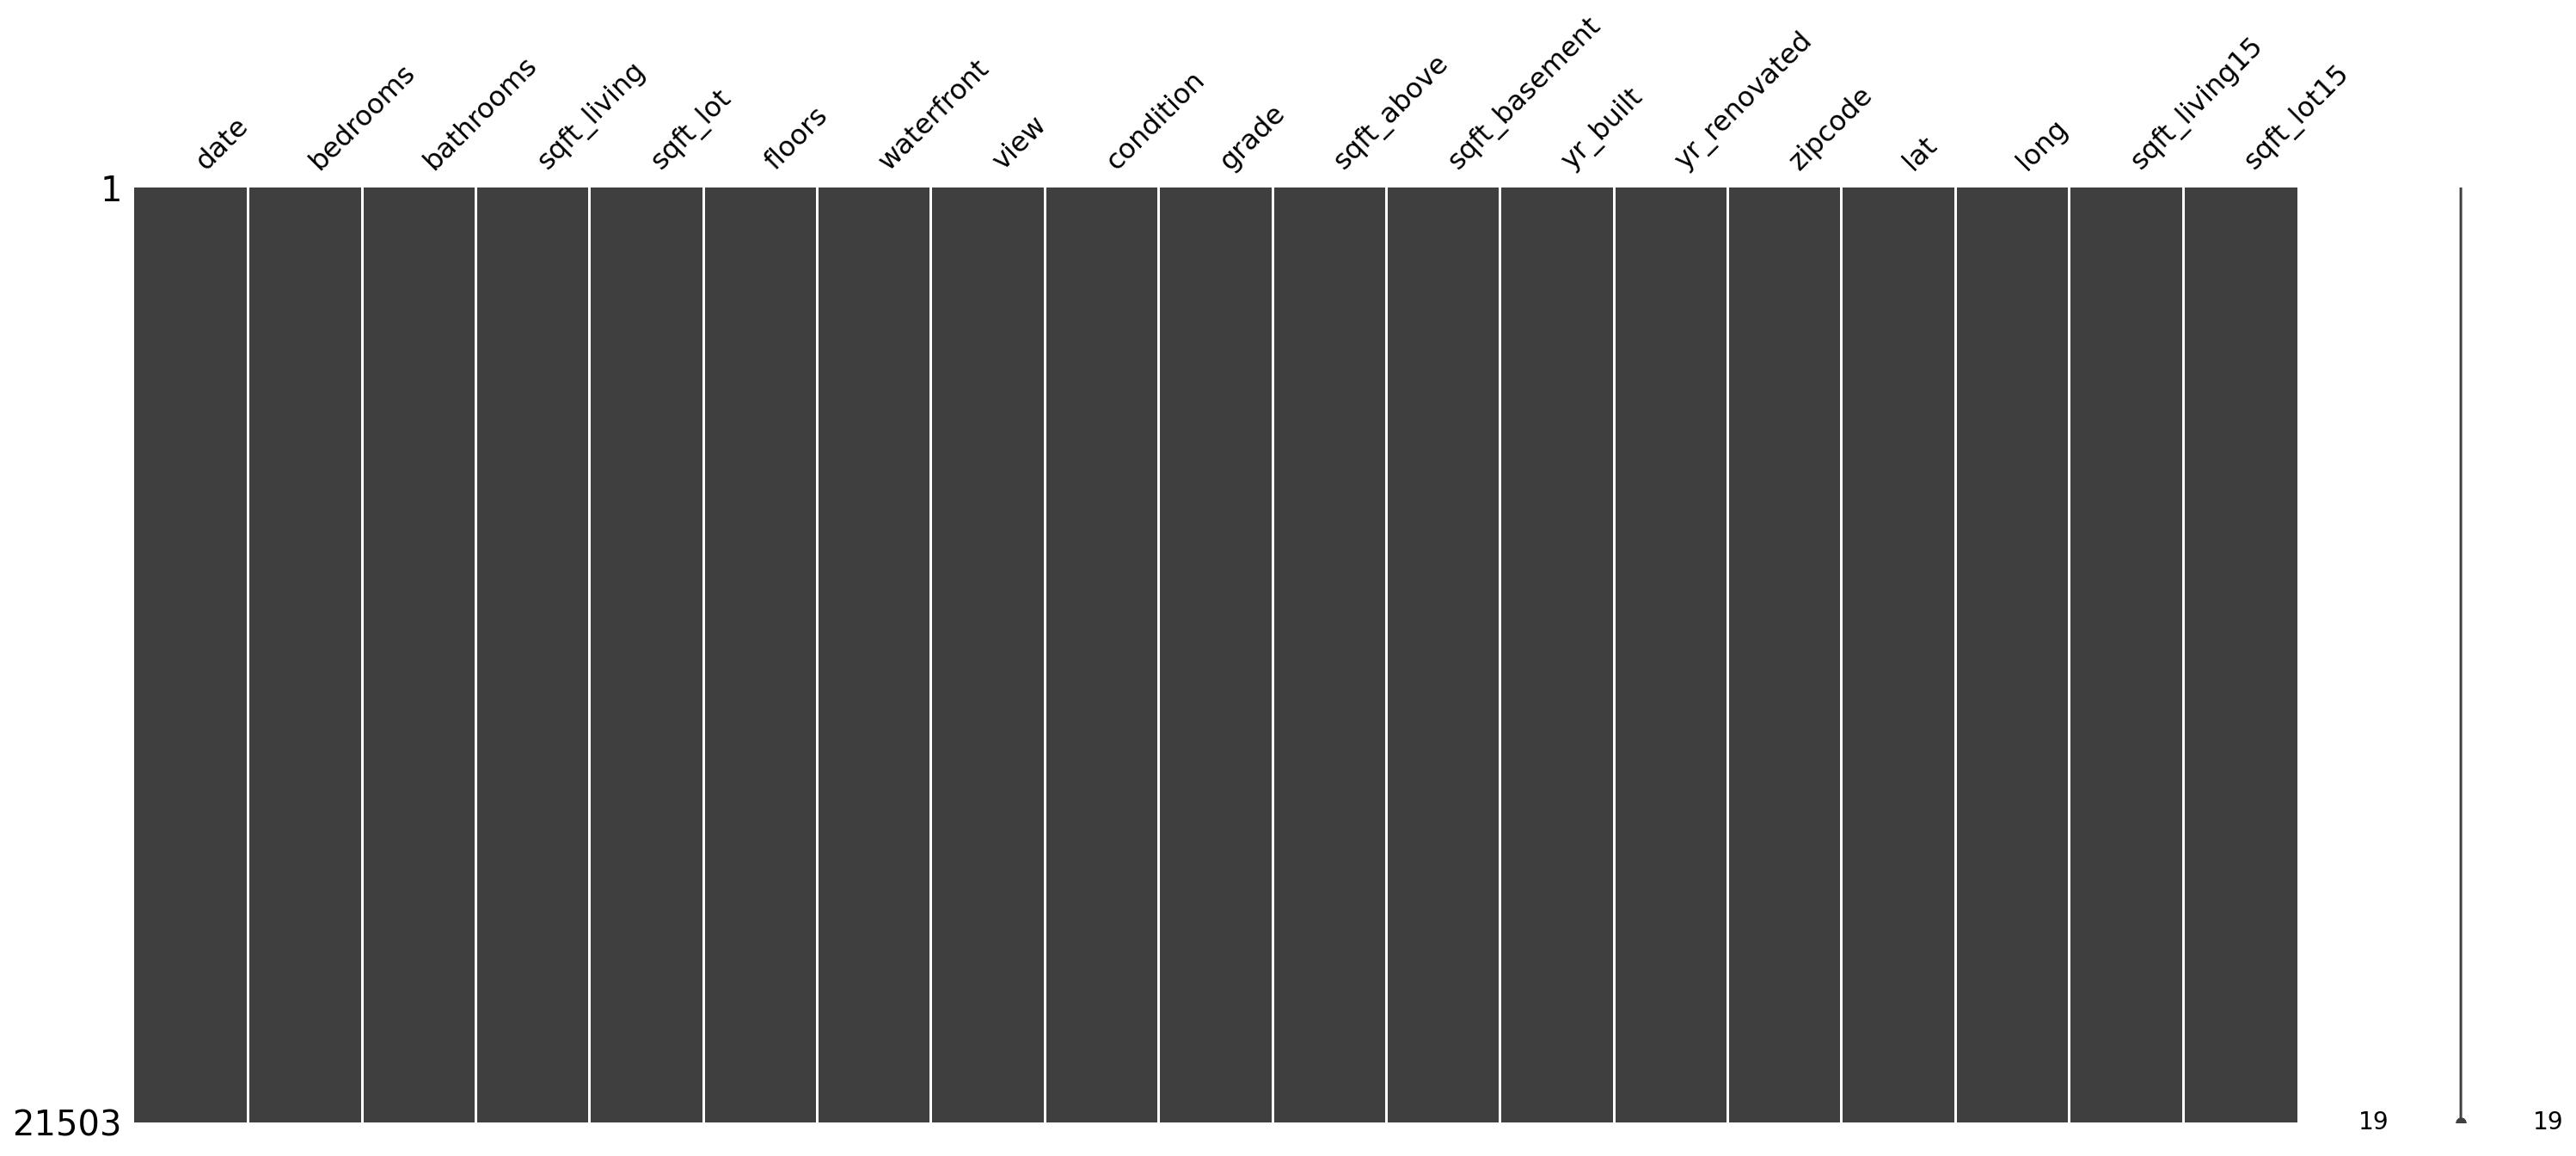

In [8]:
msno.matrix(data)

-> 다행히도 결측치는 없음을 알 수 있다.

- 컬럼들에 대해서 값 분포를 확인해보자

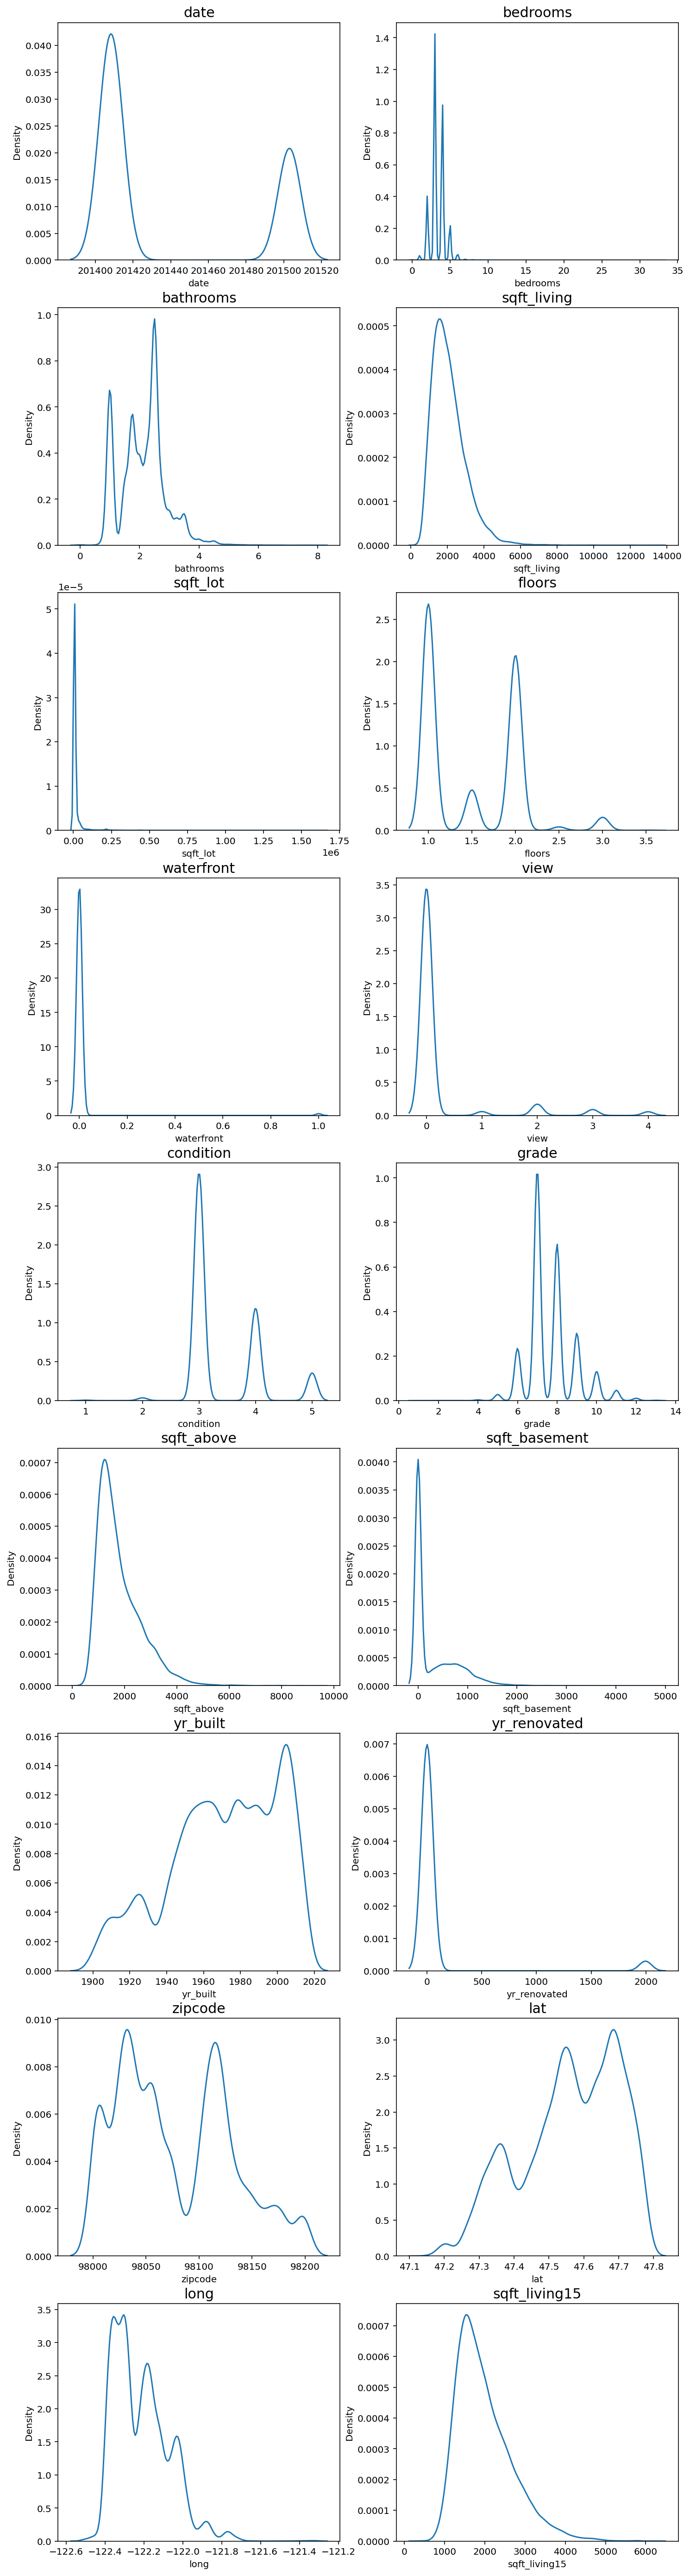

In [9]:
fig, ax = plt.subplots(9, 2, figsize=(12, 50)) 

count = 0
columns = data.columns
for row in range(9):
    for col in range(2):
        sns.kdeplot(data=data[columns[count]], ax=ax[row][col])
        ax[row][col].set_title(columns[count], fontsize=15)
        count += 1
        if count == 19 :
            break

타겟인 y 값을 확인해보자.

In [10]:
y

0         221900.0
1         180000.0
2         510000.0
3         257500.0
4         291850.0
           ...    
15030     610685.0
15031    1007500.0
15032     360000.0
15033     400000.0
15034     325000.0
Name: price, Length: 15035, dtype: float64

price는 왼쪽으로 크게 치우쳐 있는 형태다.

따라서 y는 np.log1p() 함수를 통해 로그 변환을 해주고,
나중에 모델이 값을 예측한 후에 다시 np.expm1()을 활용해서 되돌려야한다.

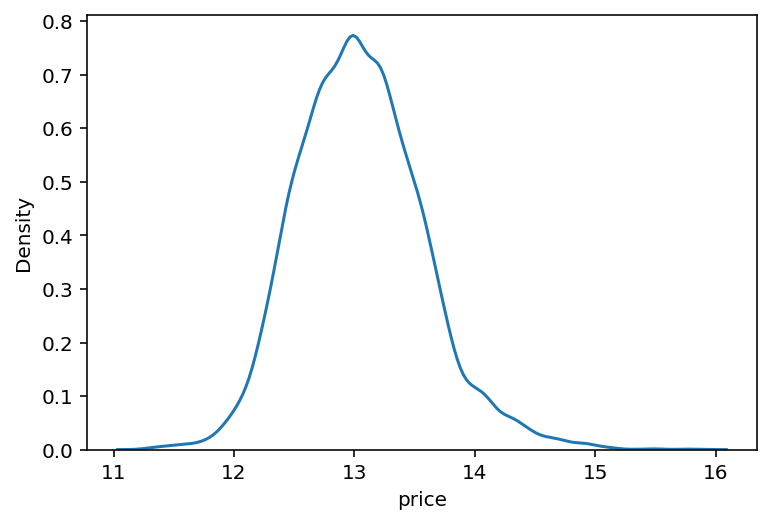

In [11]:
# 치우쳐진 y값을 정규분포 형태로 보정
y = np.log1p(y)

sns.kdeplot(y)
plt.show()

정규분포 형태로 변환 완료

In [12]:
## info()함수로 전체 자료형 확인
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15035 entries, 0 to 15034
Data columns (total 19 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   date           15035 non-null  int32  
 1   bedrooms       15035 non-null  int64  
 2   bathrooms      15035 non-null  float64
 3   sqft_living    15035 non-null  int64  
 4   sqft_lot       15035 non-null  int64  
 5   floors         15035 non-null  float64
 6   waterfront     15035 non-null  int64  
 7   view           15035 non-null  int64  
 8   condition      15035 non-null  int64  
 9   grade          15035 non-null  int64  
 10  sqft_above     15035 non-null  int64  
 11  sqft_basement  15035 non-null  int64  
 12  yr_built       15035 non-null  int64  
 13  yr_renovated   15035 non-null  int64  
 14  zipcode        15035 non-null  int64  
 15  lat            15035 non-null  float64
 16  long           15035 non-null  float64
 17  sqft_living15  15035 non-null  int64  
 18  sqft_l

모두 실수 또는 정수 자료형으로, 문제 없이 모델 학습에 활용할 수 있을 것으로 보인다.

# model tunning

train/test dataset을 나누기 위한 train_test_split 함수와, RMSE 점수를 계산하기 위한 mean_squared_error를 import  
이후의 함수 코드는 LMS를 통해 획득 후 정리했습니다.

In [13]:
# import
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

# RMSE값 얻기 위한 함수
def rmse(y_test, y_pred):
    return np.sqrt(mean_squared_error(np.expm1(y_test), np.expm1(y_pred)))

# 모델 import
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor


### 모델 인스턴스 생성 후 models에 저장
# random_state는 모델초기화나 데이터셋 구성에 사용되는 랜덤 시드값입니다. 
# random_state=None    # 이게 초기값입니다. 아무것도 지정하지 않고 None을 넘겨주면 모델 내부에서 임의로 선택합니다.  
random_state=2020        # 하지만 우리는 이렇게 고정값을 세팅해 두겠습니다. 

gboost = GradientBoostingRegressor(random_state=random_state)
xgboost = XGBRegressor(random_state=random_state)
lightgbm = LGBMRegressor(random_state=random_state)
rdforest = RandomForestRegressor(random_state=random_state)

models = [gboost, xgboost, lightgbm, rdforest]


# 점수를 얻기 위한 함수
def get_scores(models, train, y):
    df = {}
    
    for model in models:
        # 모델 이름 획득
        model_name = model.__class__.__name__
        
        # train, test 데이터셋 분리
        X_train, X_test, y_train, y_test = train_test_split(train, y, random_state=random_state, test_size=0.2)
        model.fit(X_train, y_train)    # 모델 학습
        y_pred = model.predict(X_test) # 예측
        
        df[model_name] = rmse(y_test, y_pred)    #예측 결과의 RMSE값 저장
        score_df = pd.DataFrame(df, index=['RMSE']).T.sort_values('RMSE', ascending=False) # data frame에 저장
            
    return score_df

get_scores(models, train, y)

,RMSE
GradientBoostingRegressor,128360.196497
RandomForestRegressor,125367.297375
LGBMRegressor,111920.367359
XGBRegressor,110318.670409


결과를 통해 사용에 유리한 함수를 뽑자면 LGBMRegressor / XGBRegressor 두가지가 유력하다.  
따라서 이후 두 모델을 사용하려한다.

# Hyper Parameter

sklearn.model_selection 라이브러리 안에 있는 GridSearchCV 클래스를 활용-하려 했지만 활용하지 않았다-만 코드는 남겨놓는다.

In [14]:
# 클래스 import
from sklearn.model_selection import GridSearchCV

### Model select & Grid search

In [15]:
# grid 탐색 함수
def my_GridSearch(model, train, y, param_grid, verbose=2, n_jobs=5):
    # GridSearchCV 모델로 초기화
    grid_model = GridSearchCV(model, param_grid=param_grid, scoring='neg_mean_squared_error', \
                              cv=5, verbose=verbose, n_jobs=n_jobs)
    
    # 모델 fitting
    grid_model.fit(train, y)

    # 결과값 저장
    params = grid_model.cv_results_['params']
    score = grid_model.cv_results_['mean_test_score']
    
    # 데이터 프레임 생성
    results = pd.DataFrame(params)
    results['score'] = score
    
    # RMSLE 값 계산 후 정렬
    results['RMSLE'] = np.sqrt(-1 * results['score'])
    results = results.sort_values('RMSLE')

    return results

In [16]:
'''
# grid 탐색
# param_grid에 탐색할 xgboost 관련 하이퍼 파라미터 입력
param_grid = {
    'n_estimators': [50, 100],
    'max_depth': [1, 10],
}

### model select
model = XGBRegressor(random_state=random_state)
my_GridSearch(model, train, y, param_grid, verbose=2, n_jobs=5)
'''

"\n# grid 탐색\n# param_grid에 탐색할 xgboost 관련 하이퍼 파라미터 입력\nparam_grid = {\n    'n_estimators': [50, 100],\n    'max_depth': [1, 10],\n}\n\n### model select\nmodel = XGBRegressor(random_state=random_state)\nmy_GridSearch(model, train, y, param_grid, verbose=2, n_jobs=5)\n"

grid search를 통해 적절한 파라메터 값을 얻고자 했지만, 반복적으로 시도해도 루브릭 평가기준 110,000점 이하를 얻기가 쉽지 않았다. 그 해결방안으로써 ensemble 기법을 사용하기로했다.

In [17]:
from sklearn.ensemble import VotingRegressor, VotingClassifier
# ensemble을 사용하기 위한 import

In [18]:
xgboost = XGBRegressor(learning_rate=0.1, max_depth=5, n_estimators=900, random_state=random_state)
lightgbm0 = LGBMRegressor(boosting='gbdt', learning_rate=0.1, num_leaves=50, max_depth=5, n_estimators=1600, random_state=random_state)
lightgbm1 = LGBMRegressor(boosting='gbdt', learning_rate=0.1, num_leaves=50, max_depth=10, n_estimators=1600, random_state=random_state)
lightgbm2 = LGBMRegressor(boosting='gbdt', learning_rate=0.1, num_leaves=60, max_depth=5, n_estimators=1900, random_state=random_state)
lightgbm3 = LGBMRegressor(boosting='gbdt', learning_rate=0.1, num_leaves=50, max_depth=10, n_estimators=1600, random_state=random_state)
predct = VotingRegressor(estimators=[('xgb', xgboost), ('lgbm0', lightgbm0), ('lgbm1', lightgbm1), ('lgbm2', lightgbm2), ('lgbm3', lightgbm3)])

'''
# 109,113
xgboost = XGBRegressor(learning_rate=0.1, max_depth=5, n_estimators=900, random_state=random_state)
lightgbm0 = LGBMRegressor(boosting='gbdt', learning_rate=0.1, num_leaves=50, max_depth=5, n_estimators=1600, random_state=random_state)
lightgbm1 = LGBMRegressor(boosting='gbdt', learning_rate=0.1, num_leaves=50, max_depth=10, n_estimators=1600, random_state=random_state)
lightgbm2 = LGBMRegressor(boosting='gbdt', learning_rate=0.1, num_leaves=60, max_depth=5, n_estimators=1900, random_state=random_state)
lightgbm3 = LGBMRegressor(boosting='gbdt', learning_rate=0.1, num_leaves=50, max_depth=10, n_estimators=1600, random_state=random_state)
predct = VotingRegressor(estimators=[('xgb', xgboost), ('lgbm0', lightgbm0), ('lgbm1', lightgbm1), ('lgbm2', lightgbm2), ('lgbm3', lightgbm3)])

xgboost = XGBRegressor(learning_rate=0.1, max_depth=5, n_estimators=900, random_state=random_state)
lightgbm0 = LGBMRegressor(boosting='gbdt', min_child_samples=27, learning_rate=0.1, num_leaves=50, max_depth=5, n_estimators=1600, random_state=random_state)
lightgbm1 = LGBMRegressor(boosting='gbdt', min_child_samples=23, learning_rate=0.1, num_leaves=50, max_depth=10, n_estimators=1700, random_state=random_state)
lightgbm2 = LGBMRegressor(boosting='gbdt', min_child_samples=24, learning_rate=0.1, num_leaves=60, max_depth=5, n_estimators=1900, random_state=random_state)
lightgbm3 = LGBMRegressor(boosting='gbdt', min_child_samples=28, learning_rate=0.1, num_leaves=50, max_depth=10, n_estimators=1800, random_state=random_state)
predct = VotingRegressor(estimators=[('xgb', xgboost), ('lgbm0', lightgbm0), ('lgbm1', lightgbm1), ('lgbm2', lightgbm2), ('lgbm3', lightgbm3)])
'''

"\n# 109,113\nxgboost = XGBRegressor(learning_rate=0.1, max_depth=5, n_estimators=900, random_state=random_state)\nlightgbm0 = LGBMRegressor(boosting='gbdt', learning_rate=0.1, num_leaves=50, max_depth=5, n_estimators=1600, random_state=random_state)\nlightgbm1 = LGBMRegressor(boosting='gbdt', learning_rate=0.1, num_leaves=50, max_depth=10, n_estimators=1600, random_state=random_state)\nlightgbm2 = LGBMRegressor(boosting='gbdt', learning_rate=0.1, num_leaves=60, max_depth=5, n_estimators=1900, random_state=random_state)\nlightgbm3 = LGBMRegressor(boosting='gbdt', learning_rate=0.1, num_leaves=50, max_depth=10, n_estimators=1600, random_state=random_state)\npredct = VotingRegressor(estimators=[('xgb', xgboost), ('lgbm0', lightgbm0), ('lgbm1', lightgbm1), ('lgbm2', lightgbm2), ('lgbm3', lightgbm3)])\n\nxgboost = XGBRegressor(learning_rate=0.1, max_depth=5, n_estimators=900, random_state=random_state)\nlightgbm0 = LGBMRegressor(boosting='gbdt', min_child_samples=27, learning_rate=0.1, num

In [19]:
model = predct


In [20]:
def save_submission(model, train, y, test, model_name, rmsle=None):
    # 훈련 및 예측
    model.fit(train, y)
    prediction = model.predict(test)
    # 보정 값 복구
    prediction = np.expm1(prediction)
    # result save
    data_dir = os.getenv('USERPROFILE')+'/Exploration/03_Kaggle/data'
    submission_path = join(data_dir, 'sample_submission.csv')
    submission = pd.read_csv(submission_path)
    submission['price'] = prediction
    submission_csv_path = '{}/submission_{}_RMSLE_{}.csv'.format(data_dir, model_name, rmsle)
    submission.to_csv(submission_csv_path, index=False)
    print('{} saved!'.format(submission_csv_path))

In [21]:
# train - test - bias - save
save_submission(model, train, y, test, 'XGBR', rmsle='13')

[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
C:\Users\seojoon.DYNO/Exploration/03_Kaggle/data/submission_XGBR_RMSLE_13.csv saved!


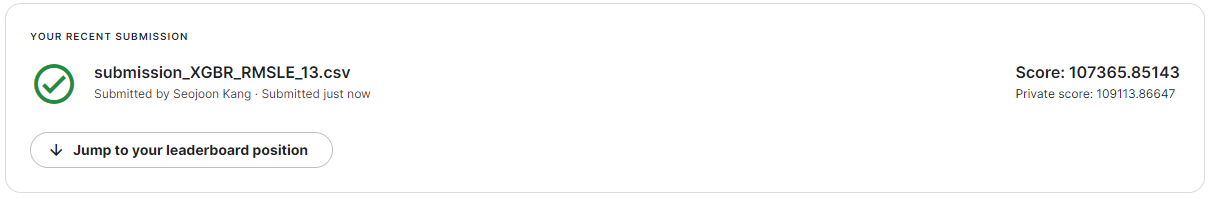

# discussion

- 최초 시작은 feature 수정을 통해 루브릭평가기준 score에 근접하기 위한 노력이 있었지만, resource(시간)가 한정된 상황이라 LMS에서 추천해준 hyper parameter를 adjustment하는 방향으로 목표를 수정했다. 그 과정에서 GridSearch를 사용하기 위한 시도도 있었지만, 이해도 부족과 너무 다양한 수를 입력해가며 진행해서 결국에는 hyper parameter를 직접 수정하며 프로젝트를 진행했다.  
- 평가기준 score에 집착해서 프로젝트의 본질과는 멀어져서 다소 아쉬웠지만, 값을 up-down게임을 하듯 조정해가며 score를 확인하는 과정에서 parameter 값이 결코 linear하지 않음을 깨닳고 두가지 모델을 ensemble하여 진행 할 아이디어를 얻을 수 있었다.  
- 중간 과정에서 주피터노트북을 정리하다가 In[9]에서 로그변환을 두번 하는 바람에 score가 비정상적으로 높아져 당황했지만, 코드를 다시 리뷰하며 발견 할 수 있었고 재밌는 디버깅 경험이었다.  
- 수많은 시도가 있었지만 가장 마지막 시도들의 kaggle submissions를 붙이며 마친다.

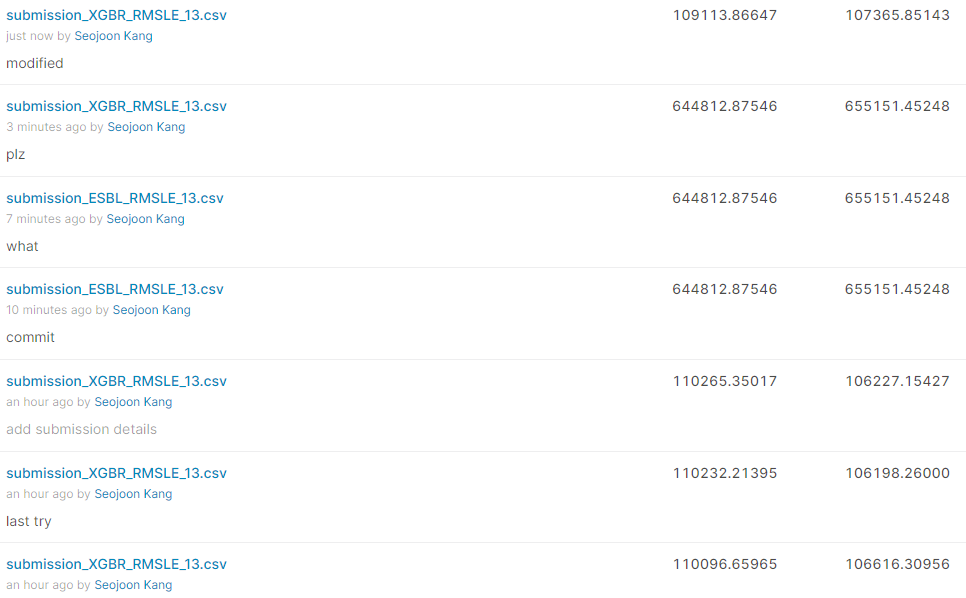